# Beer Classifier 
### Zach Sahlin Caleb Barker
### CPSC 322
The goal of this project is to be able to classify if any given beer will be good or not.  We got our data from data world and additionally used the google api to get the locations of the breweries.  Through this notbook we run multiple classifiers to try and figure out which one will be the best and We ended up finding that our decision tree was the best 

In [59]:
# some useful mysklearn package import statements and reloads
import importlib
import os
from matplotlib import pyplot as plt

import mysklearn.myutils
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as myutils

# uncomment once you paste your mypytable.py into mysklearn package
import mysklearn.mypytable
importlib.reload(mysklearn.mypytable)
from mysklearn.mypytable import MyPyTable 

# uncomment once you paste your myclassifiers.py into mysklearn package
import mysklearn.myclassifiers
importlib.reload(mysklearn.myclassifiers)
from mysklearn.myclassifiers import MyKNeighborsClassifier, MyDummyClassifier, MyNaiveBayesClassifier, MyDecisionTreeClassifier, MyRandomForestClassifier

import mysklearn.myevaluation
importlib.reload(mysklearn.myevaluation)
import mysklearn.myevaluation as myevaluation

import utils
importlib.reload(utils)
import utils as utils

In [60]:
fpath = os.path.join("Data", "beer_reviews_cleaned.csv")
table = MyPyTable().load_from_file(fpath)

## Data Analysis

### Beer Styles
We need to better understand the different values for the style of beer in order to make decisions on how to treat that attribute. If there are too many different styles, then we will need to combine similar styles. We will count the number of instances with each style and make a bar chart displaying the frequencies of each beer style.

First, we need to count the frequencies of each style. This can be done with the code.

In [61]:
styles = table.get_column("beer_style")

style_counts = {}
for style in styles:
    if style not in style_counts:
        style_counts[style] = 1
    else:
        style_counts[style] += 1


In [62]:
ratings = table.get_column("rating")

Now that the counts of all of the styles are stored in a dictionary, we can use matplotlib to create a bar chart using `plt.bar()`.

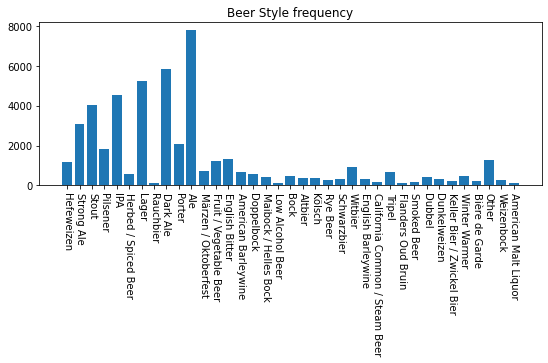

In [63]:
plt.figure(figsize=(9,3))
plt.bar(style_counts.keys(), style_counts.values())
plt.xticks(rotation= -90)
plt.title("Beer Style frequency")
plt.xlabel("")
plt.show()


In [64]:
hi = 0 
low =0
for val in table.data:
    if val[-1]  == "high":
        hi = hi + 1 
    else:
        low = low + 1 
print("Instances:",len(table.data))
print("Low Rating Instances",low, low/len(table.data))
print("High Rating Instances",hi , hi/len(table.data))



Instances: 49001
Low Rating Instances 28397 0.5795187853309116
High Rating Instances 20604 0.4204812146690884


## Classification

We want to test to make sure that our data can be classified. We will do this by creating multiple classifiers and testing their performance over the dataset.

First, we need to split the data into X and y. Our y attribute, or class attribute, is the rating, because we are trying to predict the rating of a beer. First, we will try to use beer_style and beer_abv as the X attributes.


In [65]:
table = table.get_columns(['beer_style', 'beer_abv', 'rating'])
table.remove_rows_with_missing_values()

X = table.get_columns(['beer_style', 'beer_abv']).data
y = table.get_column('rating')


Next, we will use stratified k-fold cross validation to train and test our classifiers with a k value of 10. This will ensure that we are testing each instance of the dataset exactly once. We are making a dummy classifier, a Naive Bayes classifier, and a decision tree classifier. We are not using a kNN classifier because the dataset is very large and it takes too long. 

In [66]:
X_train_folds, X_test_folds = myevaluation.stratified_kfold_cross_validation(X, y, 5, random_state=0, shuffle=True)

dummy_y_pred = []
knn_y_pred = []
nb_y_pred = []
dt_y_pred = []
rf_y_pred = []
y_true = []
for fold in range(len(X_train_folds)):
    X_train = [X[index] for index in X_train_folds[fold]]
    y_train = [y[index] for index in X_train_folds[fold]]
    X_test = [X[index] for index in X_test_folds[fold]]
    y_test = [y[index] for index in X_test_folds[fold]]

    dummy_clf = MyDummyClassifier()
    dummy_clf.fit(X_train, y_train)
    dummy_y_pred.extend(dummy_clf.predict(X_test))

    # knn_clf = MyKNeighborsClassifier(5)
    # knn_clf.fit(X_train, y_train)
    # knn_y_pred.extend(knn_clf.predict(X_test))

    nb_clf = MyNaiveBayesClassifier()
    nb_clf.fit(X_train, y_train)
    nb_y_pred.extend(nb_clf.predict(X_test))

    dt_clf = MyDecisionTreeClassifier()
    dt_clf.fit(X_train, y_train)
    dt_y_pred.extend(dt_clf.predict(X_test))

    rf_clf = MyRandomForestClassifier(4, 10, 2)
    rf_clf.fit(X_train, y_train)
    rf_y_pred.extend(rf_clf.predict(X_test))

    y_true.extend(y_test)

In [67]:
labels = ["high", "low"]
pos_label = "high"

utils.measure_performance(y_true, dummy_y_pred, labels, pos_label, "Dummy")

Dummy Perfomance:
Accuracy: 0.5787385471204188
Error rate: 0.42126145287958117
Precision: 0.0
Recall: 0.0
F1 measure: 0.0
Confusion Matrix:
        high    low    Total    Recognition %
----  ------  -----  -------  ---------------
high       0  20598    20598                0
low        0  28298    28298              100


In [68]:
# utils.measure_performance(y_true, knn_y_pred, labels, pos_label, "KNN")


Saved KNN results from when it ran earlier
![KNN](other/KNN%20Performance.png)

In [69]:
utils.measure_performance(y_true, nb_y_pred, labels, pos_label, "Naive Bayes")

Naive Bayes Perfomance:
Accuracy: 0.5975744437172775
Error rate: 0.4024255562827225
Precision: 0.5271313262240028
Recall: 0.43436255947179336
F1 measure: 0.47627159245162487
Confusion Matrix:
        high    low    Total    Recognition %
----  ------  -----  -------  ---------------
high    8947  11651    20598               43
low     8026  20272    28298               72


In [70]:
utils.measure_performance(y_true, dt_y_pred, labels, pos_label, "Decision Tree")

Decision Tree Perfomance:
Accuracy: 0.5988015379581152
Error rate: 0.4011984620418848
Precision: 0.5382933874619408
Recall: 0.3347412370133023
F1 measure: 0.4127877390965965
Confusion Matrix:
        high    low    Total    Recognition %
----  ------  -----  -------  ---------------
high    6895  13703    20598               33
low     5914  22384    28298               79


In [71]:
utils.measure_performance(y_true, rf_y_pred, labels, pos_label, "Random Forest")

Random Forest Perfomance:
Accuracy: 0.5974721858638743
Error rate: 0.4025278141361257
Precision: 0.5354598947042428
Recall: 0.3357607534712108
F1 measure: 0.41272304111714514
Confusion Matrix:
        high    low    Total    Recognition %
----  ------  -----  -------  ---------------
high    6916  13682    20598               34
low     6000  22298    28298               79


Using these attributes did not give us very good results. The decision tree had the highest accuracy with 76.3%, which is only marginally higher than the dummy classifier accuracy of 74.1%.

### Using More Attributes
Due to the poor results previously, we decided to collect more data to use. We used the Google Places API to get more data on the breweries. This is done in the file named `places_api.ipynb`. We were able to get address, price level, and rating of each brewery. This data has been combined into `joined_data.csv`.

First, we need to load in this new data.

In [72]:
joined_path = os.path.join("Data", "joined_data.csv")
joined_table = MyPyTable().load_from_file(joined_path)

Next, we need to split the data into X and y. We will keep rating as our y attribute, but this time, we will use beer_style, beer_abv, brewery_rating, and brewery_country as the X attributes.

In [73]:
joined_table = joined_table.get_columns(['beer_style', 'beer_abv', 'rating', 'brewery_country', 'brewery_rating'])
joined_table.remove_rows_with_missing_values()
print(joined_table.column_names)
X_2 = joined_table.get_columns(['beer_style', 'beer_abv', 'brewery_country', 'brewery_rating']).data
y_2 = joined_table.get_column('rating')

['beer_style', 'beer_abv', 'rating', 'brewery_country', 'brewery_rating']


In [74]:
X_train_folds_2, X_test_folds_2 = myevaluation.stratified_kfold_cross_validation(X_2, y_2, 2, random_state=0, shuffle=True)

dummy_y_pred_2 = []
# knn_y_pred_2 = []
nb_y_pred_2 = []
dt_y_pred_2 = []
rf_y_pred = []
y_true_2 = []
for fold in range(len(X_train_folds_2)):
    X_train = [X_2[index] for index in X_train_folds_2[fold]]
    y_train = [y_2[index] for index in X_train_folds_2[fold]]
    X_test = [X_2[index] for index in X_test_folds_2[fold]]
    y_test = [y_2[index] for index in X_test_folds_2[fold]]

    dummy_clf = MyDummyClassifier()
    dummy_clf.fit(X_train, y_train)
    dummy_y_pred_2.extend(dummy_clf.predict(X_test))

    # knn_clf = MyKNeighborsClassifier(5)
    # knn_clf.fit(X_train, y_train)
    # knn_y_pred_2.extend(knn_clf.predict(X_test))

    # nb_clf = MyNaiveBayesClassifier()
    # nb_clf.fit(X_train, y_train)
    # nb_y_pred_2.extend(nb_clf.predict(X_test))

    dt_clf = MyDecisionTreeClassifier()
    dt_clf.fit(X_train, y_train)
    dt_y_pred_2.extend(dt_clf.predict(X_test))

    rf_clf = MyRandomForestClassifier(4, 10, 2)
    rf_clf.fit(X_train, y_train)
    rf_y_pred.extend(rf_clf.predict(X_test))

    y_true_2.extend(y_test)

In [75]:
labels = ["high", "low"]
pos_label = "high"

utils.measure_performance(y_true_2, dummy_y_pred_2, labels, pos_label, "Dummy")

Dummy Perfomance:
Accuracy: 0.5704928664072633
Error rate: 0.42950713359273673
Precision: 0.0
Recall: 0.0
F1 measure: 0.0
Confusion Matrix:
        high    low    Total    Recognition %
----  ------  -----  -------  ---------------
high       0  19869    19869                0
low        0  26391    26391              100


In [76]:
# utils.measure_performance(y_true_2, knn_y_pred_2, labels, pos_label, "KNN")

In [77]:
utils.measure_performance(y_true_2, nb_y_pred_2, labels, pos_label, "Naive Bayes")

IndexError: list index out of range

In [78]:
utils.measure_performance(y_true_2, dt_y_pred_2, labels, pos_label, "Decision Tree")

Decision Tree Perfomance:
Accuracy: 0.5938175529615218
Error rate: 0.40618244703847817
Precision: 0.5440013049506566
Recall: 0.3356988273189391
F1 measure: 0.41518829754123876
Confusion Matrix:
        high    low    Total    Recognition %
----  ------  -----  -------  ---------------
high    6670  13199    19869               34
low     5591  20800    26391               79


In [80]:
utils.measure_performance(y_true, rf_y_pred, labels, pos_label, "Random Forest")

IndexError: list index out of range